In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.datasets import cifar10
from keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-3-08eaae540803>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [4]:
num_classes = 10
input_shape = (32, 32, 3)
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
n=5000
x_train = x_train[1:n]; y_train=y_train[1:n]
x_test=x_test[1:500]; y_test=y_test[1:500]
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print("orig x_train shape:", x_train.shape)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 6s 0us/step
orig x_train shape: (4999, 32, 32, 3)


## SGD

In [5]:
# Define the model architecture
def build_model(hp):
  use_saved_model = False
  if use_saved_model:
    model = keras.models.load_model("/content/drive/MyDrive/pruthvirai/CIFAR_CNN/RandomSearch_SGD.model")
    return model
  else:
    model = Sequential()
    model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:],activation='relu'))
    model.add(Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1(0.0001)))
  
    # Compile the model with the given learning rate, momentum and nesterov values
    model.compile(optimizer=keras.optimizers.SGD(
                                        learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]),
                                        momentum=hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]),
                                        nesterov=True
                                        ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
# Define the hyperparameters search space
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=5,
    overwrite=True,
    directory='/content/drive/MyDrive/pruthvirai/CIFAR_CNN',
    project_name='nesterov_random_search_sgd_tuner'
)

In [7]:
import time
start = time.time()
tuner.search(x_train, y_train, validation_split=0.2)

Trial 15 Complete [00h 00m 14s]
val_accuracy: 0.13120000064373016

Best val_accuracy So Far: 0.25759999454021454
Total elapsed time: 00h 03m 44s


In [8]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal momentum for the optimizer is {best_hps.get('momentum')}.
""")


The hyperparameter search is complete. 
The optimal learning rate for the optimizer is 0.01.
The optimal momentum for the optimizer is 0.9.



In [9]:
best_sgd_model = tuner.hypermodel.build(best_hps)
sgd_history = best_sgd_model.fit(x_train, y_train, epochs=20, validation_split=0.2)
end = time.time()
print(f"Runtime of the program is {end - start}")

Epoch 1/20
125/125 [==============================] - 2s 7ms/step - loss: 2.2429 - accuracy: 0.1820 - val_loss: 2.0708 - val_accuracy: 0.2670
Epoch 2/20
125/125 [==============================] - 1s 6ms/step - loss: 2.0556 - accuracy: 0.2821 - val_loss: 2.0166 - val_accuracy: 0.2740
Epoch 3/20
125/125 [==============================] - 1s 6ms/step - loss: 1.9723 - accuracy: 0.3146 - val_loss: 1.9365 - val_accuracy: 0.3090
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 1.8813 - accuracy: 0.3396 - val_loss: 1.8307 - val_accuracy: 0.3650
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 1.7915 - accuracy: 0.3713 - val_loss: 1.6986 - val_accuracy: 0.4160
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 1.7047 - accuracy: 0.4194 - val_loss: 1.6420 - val_accuracy: 0.4510
Epoch 7/20
125/125 [==============================] - 1s 8ms/step - loss: 1.6223 - accuracy: 0.4459 - val_loss: 1.6243 - val_accuracy: 0.4450
Epoch 

In [10]:
best_sgd_model.save("/content/drive/MyDrive/CIFAR_CNN/RandomSearch_SGD.model")

In [11]:
val_acc_per_epoch = sgd_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 15


In [12]:
import pandas as pd
pd.DataFrame(sgd_history.history)

,loss,accuracy,val_loss,val_accuracy
0,2.242897,0.182046,2.070790,0.267
1,2.055574,0.282071,2.016631,0.274
2,1.972294,0.314579,1.936465,0.309
3,1.881283,0.339585,1.830657,0.365
4,1.791550,0.371343,1.698595,0.416
5,1.704695,0.419355,1.642049,0.451
6,1.622271,0.445861,1.624318,0.445
7,1.542739,0.468117,1.629699,0.434
8,1.495761,0.477619,1.566723,0.470
9,1.436945,0.508627,1.585784,0.464


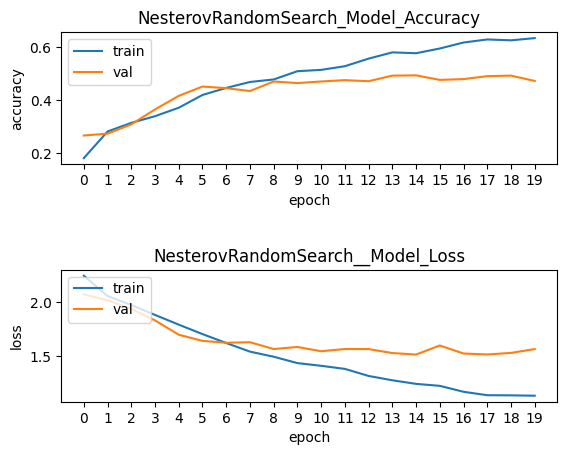

In [28]:
plt.subplot(211)
plt.plot(sgd_history.history['accuracy'])
plt.plot(sgd_history.history['val_accuracy'])
plt.title('NesterovRandomSearch_Model_Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, 20, 1))
plt.subplot(212)
plt.plot(sgd_history.history['loss'])
plt.plot(sgd_history.history['val_loss'])
plt.title('NesterovRandomSearch__Model_Loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, 20, 1))
plt.subplots_adjust(hspace=0.8)
# plt.show()
images_dir = '/content/drive/MyDrive/pruthvirai/CIFAR_CNN'
plt.savefig(f"{images_dir}/randomsearch_sgd.png")

In [14]:
preds = best_sgd_model.predict(x_train)
y_pred = np.argmax(preds, axis=1)
y_train1 = np.argmax(y_train, axis=1)
print(classification_report(y_train1, y_pred))
print(confusion_matrix(y_train1,y_pred))

157/157 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       505
           1       0.88      0.78      0.83       460
           2       0.74      0.56      0.64       519
           3       0.75      0.52      0.61       486
           4       0.57      0.75      0.65       519
           5       0.74      0.65      0.69       488
           6       0.67      0.77      0.72       518
           7       0.71      0.82      0.76       486
           8       0.80      0.75      0.77       520
           9       0.76      0.83      0.79       498

    accuracy                           0.72      4999
   macro avg       0.74      0.72      0.72      4999
weighted avg       0.73      0.72      0.72      4999

[[409   5   7   0   9   0   5  13  41  16]
 [  9 360   1   1   6   1  10   8  21  43]
 [ 24   5 292  17  84  16  35  25   9  12]
 [  6   2  22 252  52  49  55  31   6  11]
 [ 19   0  16 

In [15]:
preds = best_sgd_model.predict(x_test)
y_pred = np.argmax(preds, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print(classification_report(y_test1, y_pred))
print(confusion_matrix(y_test1,y_pred))

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.57      0.56      0.57        57
           1       0.62      0.56      0.59        41
           2       0.57      0.45      0.51        51
           3       0.28      0.19      0.23        48
           4       0.29      0.40      0.33        40
           5       0.38      0.29      0.33        48
           6       0.48      0.59      0.53        54
           7       0.40      0.55      0.46        47
           8       0.59      0.51      0.55        57
           9       0.64      0.70      0.67        56

    accuracy                           0.49       499
   macro avg       0.48      0.48      0.48       499
weighted avg       0.49      0.49      0.48       499

[[32  2  3  1  2  0  3  1  8  5]
 [ 1 23  0  1  1  0  2  0  6  7]
 [ 2  2 23  1  9  3  5  5  0  1]
 [ 0  0  4  9  4  9 13  6  0  3]
 [ 0  3  2  2 16  5  7  5  0  0]
 [ 0  0  3  6  8 14  2 

## Adam

In [16]:
# Define the model architecture
def build_model(hp):
  use_saved_model = False
  if use_saved_model:
    model = keras.models.load_model("/content/drive/MyDrive/pruthvirai/CIFAR_CNN/RandomSearch_Adam.model")
    return model
  else:
    model = Sequential()
    model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:],activation='relu'))
    model.add(Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1(0.0001)))

    # Compile the model with the given learning rate, momentum and nesterov values
    model.compile(optimizer=Adam(
                                    learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]),
                                    beta_1=hp.Choice('beta_1', [0.8, 0.9, 0.95, 0.99]),
                                    beta_2=hp.Choice('beta_2', [0.8, 0.9, 0.95, 0.99]),
                                    ),
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"],
    )
    return model

In [17]:
# Define the hyperparameters search space
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=5,
    overwrite=True,
    directory='/content/drive/MyDrive/pruthvirai/CIFAR_CNN',
    project_name='nesterov_random_search_adam_tuner'
)

In [18]:
import time
start = time.time()
tuner.search(x_train, y_train, validation_split=0.2)

Trial 20 Complete [00h 00m 24s]
val_accuracy: 0.24859999716281891

Best val_accuracy So Far: 0.3118000030517578
Total elapsed time: 00h 06m 49s


In [19]:
best_hps_adam = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
The optimal learning rate for the optimizer is {best_hps_adam.get('learning_rate')}.
The optimal beta_1 for the optimizer is {best_hps_adam.get('beta_1')}.
The optimal beta_1 for the optimizer is {best_hps_adam.get('beta_2')}.
""")


The hyperparameter search is complete. 
The optimal learning rate for the optimizer is 0.001.
The optimal beta_1 for the optimizer is 0.8.
The optimal beta_1 for the optimizer is 0.8.



In [20]:
adam_sgd_model = tuner.hypermodel.build(best_hps_adam)
adam_history = adam_sgd_model.fit(x_train, y_train, epochs=20, validation_split=0.2)
end = time.time()
print(f"Runtime of the program is {end - start}")

Epoch 1/20
125/125 [==============================] - 7s 12ms/step - loss: 2.1811 - accuracy: 0.1940 - val_loss: 1.9364 - val_accuracy: 0.3330
Epoch 2/20
125/125 [==============================] - 1s 10ms/step - loss: 1.8832 - accuracy: 0.3346 - val_loss: 1.8224 - val_accuracy: 0.3830
Epoch 3/20
125/125 [==============================] - 1s 10ms/step - loss: 1.7507 - accuracy: 0.3863 - val_loss: 1.6819 - val_accuracy: 0.4270
Epoch 4/20
125/125 [==============================] - 1s 9ms/step - loss: 1.6757 - accuracy: 0.4249 - val_loss: 1.6361 - val_accuracy: 0.4540
Epoch 5/20
125/125 [==============================] - 1s 10ms/step - loss: 1.6180 - accuracy: 0.4451 - val_loss: 1.6660 - val_accuracy: 0.4230
Epoch 6/20
125/125 [==============================] - 1s 10ms/step - loss: 1.5693 - accuracy: 0.4586 - val_loss: 1.5885 - val_accuracy: 0.4620
Epoch 7/20
125/125 [==============================] - 2s 14ms/step - loss: 1.5275 - accuracy: 0.4769 - val_loss: 1.6555 - val_accuracy: 0.4380


In [21]:
adam_sgd_model.save("/content/drive/MyDrive/pruthvirai/CIFAR_CNN/RandomSearch_Adam.model")

In [22]:
val_acc_per_epoch = adam_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 14


In [23]:
import pandas as pd
pd.DataFrame(adam_history.history)

,loss,accuracy,val_loss,val_accuracy
0,2.181096,0.194049,1.936411,0.333
1,1.883221,0.334584,1.822396,0.383
2,1.750718,0.386347,1.681863,0.427
3,1.675731,0.424856,1.636087,0.454
4,1.618022,0.445111,1.665962,0.423
5,1.569271,0.458615,1.588549,0.462
6,1.527537,0.476869,1.655468,0.438
7,1.490028,0.496874,1.566928,0.484
8,1.448528,0.519130,1.547894,0.485
9,1.426553,0.523381,1.587038,0.482


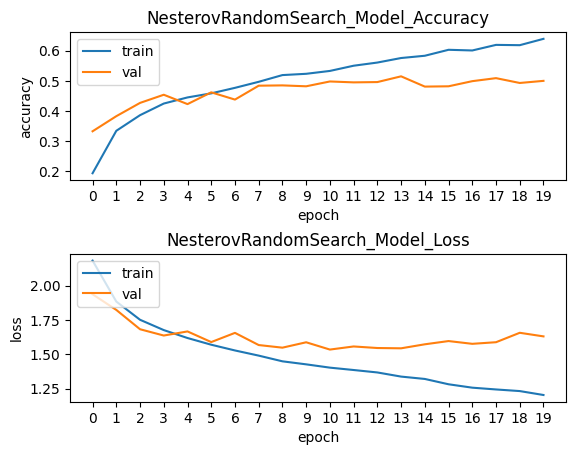

In [31]:
plt.subplot(211)
plt.plot(adam_history.history['accuracy'])
plt.plot(adam_history.history['val_accuracy'])
plt.title('NesterovRandomSearch_Model_Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, 20, 1))
plt.subplot(212)
plt.plot(adam_history.history['loss'])
plt.plot(adam_history.history['val_loss'])
plt.title('NesterovRandomSearch_Model_Loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplots_adjust(hspace=0.5)
plt.xticks(np.arange(0, 20, 1))
# plt.show()
images_dir = '/content/drive/MyDrive/pruthvirai/CIFAR_CNN'
plt.savefig(f"{images_dir}/randomsearch_adam.png")

In [25]:
preds = adam_sgd_model.predict(x_train)
y_pred = np.argmax(preds, axis=1)
y_train1 = np.argmax(y_train, axis=1)
print(classification_report(y_train1, y_pred))
print(confusion_matrix(y_train1,y_pred))

157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.77      0.57      0.65       505
           1       0.90      0.56      0.69       460
           2       0.61      0.60      0.61       519
           3       0.54      0.63      0.58       486
           4       0.58      0.58      0.58       519
           5       0.66      0.63      0.64       488
           6       0.76      0.67      0.71       518
           7       0.69      0.76      0.72       486
           8       0.71      0.80      0.75       520
           9       0.62      0.87      0.72       498

    accuracy                           0.67      4999
   macro avg       0.68      0.67      0.67      4999
weighted avg       0.68      0.67      0.67      4999

[[286   2  23  12  16   5   2  23  98  38]
 [  8 257   2   6   9   4   6  10  23 135]
 [ 20   0 312  39  56  30  15  23  17   7]
 [  4   0  30 308  38  40  24  20   5  17]
 [ 12   1  64 

In [26]:
preds = adam_sgd_model.predict(x_test)
y_pred = np.argmax(preds, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print(classification_report(y_test1, y_pred))
print(confusion_matrix(y_test1,y_pred))

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.33      0.43        57
           1       0.80      0.39      0.52        41
           2       0.49      0.41      0.45        51
           3       0.31      0.42      0.36        48
           4       0.30      0.35      0.33        40
           5       0.46      0.33      0.39        48
           6       0.65      0.61      0.63        54
           7       0.41      0.53      0.46        47
           8       0.57      0.61      0.59        57
           9       0.55      0.84      0.66        56

    accuracy                           0.49       499
   macro avg       0.51      0.48      0.48       499
weighted avg       0.52      0.49      0.49       499

[[19  0  4  2  2  1  1  4 15  9]
 [ 1 16  1  1  1  0  0  1  5 15]
 [ 3  0 21  8  7  5  3  2  1  1]
 [ 0  0  4 20  5  4  6  5  0  4]
 [ 1  1  6  3 14  2  5  7  0  1]
 [ 0  0  1 11  6 16  1 